# Time-Series Modeling, Part 2

In this lesson, we will use the BART ridership data to build an ARIMA model.  The python lesson is adapted from here: 

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

But a better desciption of the process is available here: 

https://www.otexts.org/fpp/

We draw material from both for this lesson.  

### Read the data, do some diagnostics, and make it stationary.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# This data has
bart = pd.read_csv('data/BARTEstimationFile.csv', parse_dates=['MONTH'], index_col='MONTH')
bart

,RIDERS,STATIONS,CASH_FARE_2010USD_BART,AVG_FARE_2010USD_BART,HH,HH_0VEH,POP,WORKERS,MEDIAN_HHINC_2010USD,SERVMILES_E_BART,...,EDHEALTH_EMP,LEISURE_EMP,OTHER_EMP,FUEL_PRICE_2010USD,FUEL_COST_2010USD,TOLL_BB_PK_2010USD,TOLL_BB_OP_2010USD,TOLL_BB_CARPOOL_2010USD,CASUAL_CARPOOL,BART_STRIKE
MONTH,,,,,,,,,,,,,,,,,,,,,
2001-01-01,321180.5238,39,3.262745,2.555435,1452556.571,187359.1429,3870692.571,1924489.571,85841.07733,25527.10573,...,314779.0,179565.0,1317382.0,2.240335,0.101833,2.490645,2.490645,0.000000,1,0
2001-02-01,334885.1053,39,3.249754,2.545259,1452696.413,187278.4921,3870052.746,1923471.413,85401.59874,25527.10573,...,319473.0,181972.0,1321821.0,2.227694,0.101182,2.480728,2.480728,0.000000,1,0
2001-03-01,340021.5455,39,3.242376,2.539481,1452836.254,187197.8413,3869412.921,1922453.254,85110.28356,25527.10573,...,321266.0,184828.0,1331919.0,2.290702,0.103965,2.475096,2.475096,0.000000,1,0
2001-04-01,333794.4286,39,3.229546,2.529432,1452976.095,187117.1905,3868773.095,1921435.095,84676.45762,25527.10573,...,321919.0,185372.0,1308563.0,2.436951,0.110519,2.465302,2.465302,0.000000,1,0
2001-05-01,333847.4545,39,3.215007,2.518045,1453115.937,187036.5397,3868133.270,1920416.937,84198.65633,25527.10573,...,323980.0,188738.0,1302376.0,2.532738,0.114777,2.454204,2.454204,0.000000,1,0
2001-06-01,329447.8095,39,3.209588,2.513801,1453255.778,186955.8889,3867493.444,1919398.778,83960.33478,25527.10573,...,326345.0,190404.0,1306233.0,2.524794,0.114330,2.450067,2.450067,0.000000,1,0
2001-07-01,324565.6000,39,3.218629,2.443754,1453395.619,186875.2381,3866853.619,1918380.619,84100.17146,25382.03327,...,294427.0,190728.0,1285061.0,2.369747,0.107228,2.456969,2.456969,0.000000,1,0
2001-08-01,321757.9130,39,3.218629,2.443754,1453535.460,186794.5873,3866213.794,1917362.460,84003.51416,25382.03327,...,289318.0,191763.0,1279206.0,2.137563,0.096759,2.456969,2.456969,0.000000,1,0
2001-09-01,321320.8421,39,3.204188,2.432790,1453675.302,186713.9365,3865573.968,1916344.302,83530.39581,25382.03327,...,319470.0,188124.0,1269755.0,2.291850,0.103782,2.445945,2.445945,0.000000,1,0


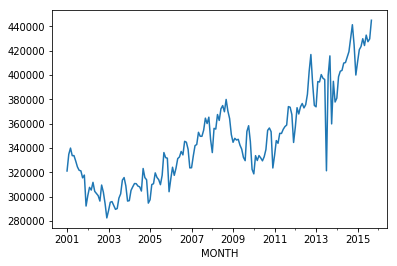

In [3]:
bart['RIDERS'].plot()

It looks to me like the data have both a trend and seasonality.  To better visualize this, we can do something called decomoposition.  This splits the time series into its trend component, its seasonal component, and the residual (everything else).  Now the trend becomes more clear...

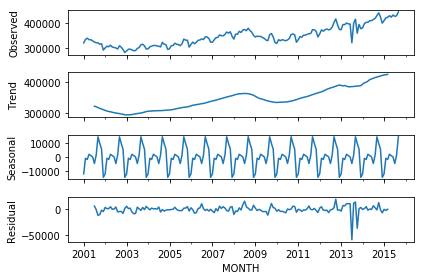

In [9]:
# This is a method in statsmodels. 
from statsmodels.tsa.seasonal import seasonal_decompose

#frequency 12 is for months in year
decomposition = seasonal_decompose(bart['RIDERS'], freq=12)  
fig = decomposition.plot()

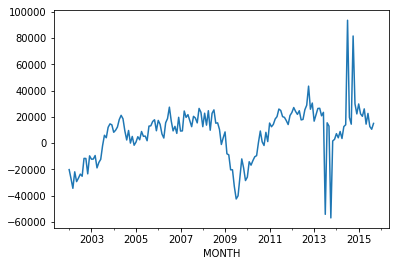

In [19]:
# since our data are not stationary, take a seasonal difference

diff = bart - bart.shift(12)
diff['RIDERS'].plot()

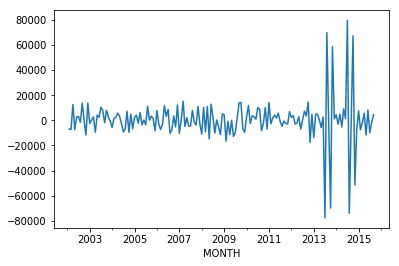

In [22]:
# looks like I still have a trend, so take the second difference

diff2 = diff - diff.shift(1)
diff2['RIDERS'].plot()

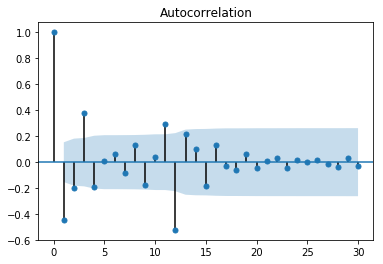

In [26]:
# and look at the ACF plot

fig = sm.graphics.tsa.plot_acf(diff2['RIDERS'][13:], lags=30)

### Let's do some models!

Now that the data are stationary, we can do some modeling on them.  We start with an autoregressive model, AR(p), which can be expressed as: 

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + e_t$

where p is the order of the model (the number of lags) and the $\phi$ values are estimated model parameters.  So this is just a regression model where the descriptive variables are past values of the time series. 

In [31]:
mod = sm.tsa.ARMA(diff2['RIDERS'][13:], (2,0))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                 RIDERS   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood               -1786.912
Method:                       css-mle   S.D. of innovations          13022.951
Date:                Thu, 12 Apr 2018   AIC                           3581.825
Time:                        13:21:28   BIC                           3594.224
Sample:                    02-01-2002   HQIC                          3586.859
                         - 09-01-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          240.5998    471.795      0.510      0.611    -684.102    1165.301
ar.L1.RIDERS    -0.6703      0.068     -9.924      0.000      -0.803      -0.538
ar.L2.RIDERS    -0.4953      0.067     -7.38

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


We could also consider a moving average model, which we might write as MA(q): 

$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q} $

Where c is a constant, e is the error or residual of the model at that time period, and the $\theta$ values are estimated coefficients. 

So this is simply a regression on past errors, rather than the values themselves. 

In [28]:
# an MA(2) model

mod = sm.tsa.ARMA(diff2['RIDERS'][13:], (0,1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                 RIDERS   No. Observations:                  164
Model:                     ARMA(0, 1)   Log Likelihood               -1797.688
Method:                       css-mle   S.D. of innovations          13920.941
Date:                Thu, 12 Apr 2018   AIC                           3601.375
Time:                        13:21:11   BIC                           3610.675
Sample:                    02-01-2002   HQIC                          3605.151
                         - 09-01-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          249.2035    427.486      0.583      0.561    -588.653    1087.060
ma.L1.RIDERS    -0.6105      0.053    -11.489      0.000      -0.715      -0.506
                                    Roots   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Or we can combine an AR(p) and an MA(q) model into an ARMA(p,q) model. 

In [35]:
# an ARMA(1,1) model

mod = sm.tsa.ARMA(diff2['RIDERS'][13:], (1,1))
res = mod.fit()
print(res.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                 RIDERS   No. Observations:                  164
Model:                     ARMA(1, 1)   Log Likelihood               -1796.843
Method:                       css-mle   S.D. of innovations          13847.635
Date:                Thu, 12 Apr 2018   AIC                           3601.686
Time:                        13:27:31   BIC                           3614.085
Sample:                    02-01-2002   HQIC                          3606.719
                         - 09-01-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          244.7152    441.593      0.554      0.580    -620.792    1110.222
ar.L1.RIDERS    -0.1428      0.106     -1.351      0.179      -0.350       0.064
ma.L1.RIDERS    -0.5370      0.080     -6.73

### What's the I? 

We started out talking about ARIMA models, so what's the I?  

ARIMA(1,0,1) is same as ARIMA(1,1)
ARIMA(1,1,1) is first difference
ARIMA(1,2,1) is second difference

Autoregressive plots help with informing variable numbers

### Some suggestions

In general, I would recommend: 

1. Make sure your data are stationary with the appriate level of differencing. 
2. Use a seasonal ARIMA model if you're working with seasonal data, and ARIMA otherwise. 
3. Use independent regressors whenever possible. 
4. Use an algorithm to auto-select the order of the models, such as: the Hyndman-Khandakar algorithm for automatic ARIMA modelling (implemented as auto.arima() in R). 